In [1]:
# # Setup
# ! sudo apt install -y libgl1-mesa-glx libglib2.0-0 libsm6 libxrender1 libxext6
# ! pip install open-iris==1.0.0 faiss-cpu seaborn

# Imports and Functions

## Imports and Constants

In [ ]:
import os
import pickle
import sys
import threading
import time
from datetime import datetime
from functools import reduce
from io import BytesIO
from itertools import combinations, product
from operator import mul
from typing import Dict, List, Tuple

In [ ]:
import boto3
import iris
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import psutil
import scipy
import seaborn as sns
from joblib import Parallel, delayed, parallel_backend
from scipy.spatial.distance import hamming
from scipy.stats import ks_2samp, ttest_ind, wasserstein_distance

In [ ]:
import hnsw
from iris.io.dataclasses import IrisTemplate
from iris_integration import (
    iris_with_noise,
    irisint_make_query as make_query,
    irisint_query_to_vector as query_to_vector,
    irisint_distance as distance,
)
from iris_pairwise_min_dist_calculation import get_pairwise_min_dist_across_rotations

In [6]:
n_jobs = 6 # Fit to CPU
DIM = (2, 32, 200)

## General Functions

In [7]:
def print_progress(msg):
    sys.stdout.write(f"\r{msg}")
    sys.stdout.flush()

In [8]:
def plot_boolean_iris(matrix, title=''):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.show()

In [9]:
def int_to_scaled_string(n):
    suffixes = ['', 'K', 'M', 'B', 'T']
    idx = max(0, min(len(suffixes) - 1, int((len(str(abs(n))) - 1) / 3)))
    scaled = n / (1000 ** idx)
    return f"{scaled:.1f}{suffixes[idx]}" if scaled % 1 else f"{int(scaled)}{suffixes[idx]}"

## Loading Functions

In [10]:
def read_partial_file(filename, num_bits):
    num_bytes = (num_bits + 7) // 8  # Ensure we round up if num_bits isn't a multiple of 8
    with open(filename, 'rb') as f:
        chunk = f.read(num_bytes)
    return np.frombuffer(chunk, dtype=np.uint8)

In [11]:
def load_and_reshape_masks(filename, num_masks, DIM=DIM):
    flattened_data = np.unpackbits(read_partial_file(filename, ((DIM[1]//2) * DIM[2]) * num_masks))
    boolean_arrays = flattened_data.reshape((num_masks, DIM[1]//2, DIM[2]))
    vertically_stacked = np.tile(boolean_arrays, (1, 2, 1))
    duplicated_arrays = np.repeat(vertically_stacked[:, np.newaxis, :, :], DIM[0], axis=1)
    return duplicated_arrays

In [12]:
def load_and_reshape_irises(path_low, path_high, num_samples, DIM=DIM):
    low_high_lst = [
        np.unpackbits(
            read_partial_file(path, (reduce(mul, DIM[1:]) * num_samples)), bitorder="little"
        ).reshape(num_samples, *DIM[1:]) for path in [path_low, path_high]
    ]
    return np.concatenate(low_high_lst, axis=1).astype(bool)

## Test Functions and DB Buildup 

In [75]:
def update_db(db, iris_df, db_size):
    db_current_size = db.get_stats()['db_size']
    assert (db_size - db_current_size) > 0
    
    new_irises = iris_df.loc[range(db_current_size, db_size), 'Template']
    for i, iris in enumerate(new_irises):
        print_progress(f'Current efConstruction: {db.efConstruction}. Insertion progress: {(i+1)/(len(new_irises)+1):.2%}')
        db.insert(make_query(iris))
    iris_df.loc[range(db_current_size, db_size), 'Inserted'] = True

In [14]:
def numpy_array_to_iris_df(iris_array, mask_array):
    def create_iris_template(matrix, mask):
        return IrisTemplate(
            iris_codes=matrix,
            mask_codes=mask, 
            # iris_code_version="v3.0" # Doesn't work on open-iris==1.0.0
        )
    iris_templates = Parallel(n_jobs=n_jobs)(delayed(create_iris_template)(list(iris), list(mask)) for iris, mask in zip(iris_array, mask_array))
    return pd.DataFrame({'Template': iris_templates}).assign(Inserted = False)

In [15]:
def calc_single_batch(batch_start: int, batch_size: int, iris_matrices: np.ndarray, mask_matrices: np.ndarray, num_matrices: int, i: int, num_batches: int) -> np.ndarray:
    print_progress(f'\rBatching progress: {(i+1)/(num_batches+1):.2%}')

    batch_end = min(batch_start + batch_size, num_matrices)
    iris_batch = iris_matrices[batch_start:batch_end]
    mask_batch = mask_matrices[batch_start:batch_end]

    valid_positions = np.expand_dims(mask_batch, axis=1) & np.expand_dims(mask_matrices, axis=0)
    differences = np.expand_dims(iris_batch, axis=1) != np.expand_dims(iris_matrices, axis=0)
    return np.sum(differences & valid_positions, axis=(-2, -1)) / np.sum(valid_positions, axis=(-2, -1))

def get_closest_M_neighbors_batched(iris_matrices: np.ndarray, mask_matrices: np.ndarray, M: int, batch_size: int = 1) -> dict:
    num_matrices = len(iris_matrices)
    num_batches = (num_matrices + batch_size - 1) // batch_size

    results = Parallel(n_jobs=n_jobs)(
        delayed(calc_single_batch)(
            batch_start=batch_start,
            batch_size=batch_size,
            iris_matrices=iris_matrices,
            mask_matrices=mask_matrices,
            num_matrices=num_matrices,
            i=i,
            num_batches=num_batches
        ) for i, batch_start in enumerate(range(0, num_matrices, batch_size))
    )
    hamming_distances = np.vstack(results)
    np.fill_diagonal(hamming_distances, np.inf)
    sorted_indices = np.argsort(hamming_distances, axis=1)
    return {
        idx: [(hamming_distances[idx, neighbor_idx], neighbor_idx) for neighbor_idx in sorted_indices[idx, :M]]
        for idx in range(num_matrices)
    }

In [70]:
def compare_neighbors_dicts(dict1, dict2, M) -> Dict[int, float]:
    match_ratios, wasserstein_dists = [], []
    for key in dict1:
        dict1_neighbors = np.array(dict1[key], dtype=[('distance', float), ('index', int)])
        dict2_neighbors = np.array(dict2.get(key, []), dtype=[('distance', float), ('index', int)])

        common_indices = np.intersect1d(dict1_neighbors['index'], dict2_neighbors['index'])
        match_ratio = len(common_indices) / M
        match_ratios.append(match_ratio)
        wasserstein_dists.append(wasserstein_distance(dict1_neighbors['distance'], dict2_neighbors['distance']))

        if len(common_indices) > 0:
            dict1_distances = dict1_neighbors['distance'][np.in1d(dict1_neighbors['index'], common_indices)]
            dict2_distances = dict2_neighbors['distance'][np.in1d(dict2_neighbors['index'], common_indices)]
            assert np.allclose(dict1_distances, dict2_distances), f"Distance mismatch for key {key} on common indices"
    
    return (wasserstein_dists, match_ratios)

# Data Loading

## Configurations

In [76]:
synthetic_data_size = 2**22
max_tested_db_size = 20000

In [77]:
path_masks = f'{int_to_scaled_string(synthetic_data_size)}_mask_arrays.dat'
path_iris_low = '2_23_voter_arrays_90k_b090.dat'
path_iris_high = '2_23_voter_arrays_14k_b010.dat'

## Loading

In [78]:
loaded_masks = load_and_reshape_masks(path_masks, max_tested_db_size).astype(bool).reshape(max_tested_db_size, reduce(mul, DIM[:2]), DIM[2])
loaded_irises = load_and_reshape_irises(path_iris_low, path_iris_high, max_tested_db_size)

## Reassuring stats

In [79]:
assert len(loaded_masks) == max_tested_db_size
assert len(loaded_irises) == max_tested_db_size
print(f'Successfuly loaded {int_to_scaled_string(max_tested_db_size)} masks and irises')

Successfuly loaded 20K masks and irises


# efConstruction test

## Configurations

In [80]:
M = 64
db_stable_size = 20000
test_precision = 11 # Amount of points tested between M -> 2M
assert db_stable_size <= max_tested_db_size

## Ideal graph calculation

In [24]:
ideal_layer0_graph = get_closest_M_neighbors_batched(loaded_irises[:db_stable_size], loaded_masks[:db_stable_size], M=2*M)

Batching progress: 100.00%

## Test 

In [81]:
iris_df = numpy_array_to_iris_df(loaded_irises.reshape(max_tested_db_size, *DIM), loaded_masks.reshape(max_tested_db_size, *DIM))

In [123]:
results, num_layers_lst = dict(), []
for efConstruction_ratio in np.linspace(1,2,test_precision):
    efConstruction = np.round(M*efConstruction_ratio).astype(int)
    db = hnsw.HNSW(
        M=M, 
        efConstruction=efConstruction, 
        m_L=1/np.log(M), 
        distance_func=distance, 
        query_to_vector_func=query_to_vector
    )
    update_db(db, iris_df, db_stable_size)
    results[efConstruction_ratio] = compare_neighbors_dicts(ideal_layer0_graph, db.layers[0], 2*M)
    distance_distribution_lst = []
    for lst in db.layers[0].values():
        distance_distribution_lst.extend([tup[0] for tup in lst])
    np.array(distance_distribution_lst).tofile(f'efConstruction_{efConstruction}.dat')
    iris_df['Inserted'] = False

Current efConstruction: 128. Insertion progress: 100.00%

In [84]:
df = pd.DataFrame(
    [
        (mul_const, dist, ratio) for mul_const, (wasserstein_dists, match_ratios) in results.items() 
        for dist, ratio in zip(wasserstein_dists, match_ratios)
    ],
    columns=['M Multiplication Constant', 'Wasserstein Distance', 'Matching Ratios']
)
df['M Multiplication Constant'] = np.round(df['M Multiplication Constant'], decimals=1)

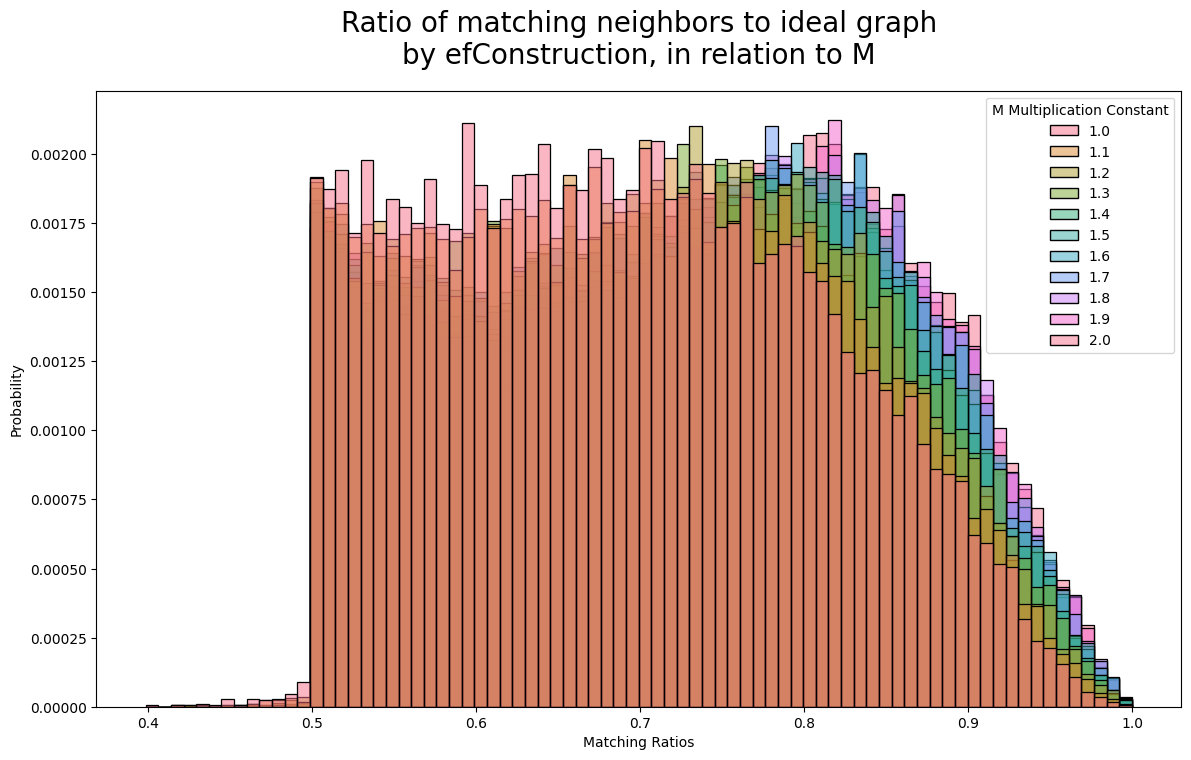

In [95]:
plt.figure(figsize=(14,8))
sns.histplot(df, x='Matching Ratios', hue='M Multiplication Constant', palette='husl', stat='probability', bins=78)
plt.title('Ratio of matching neighbors to ideal graph\nby efConstruction, in relation to M', y=1.03, fontsize=20)
plt.show()

In [128]:
data_lst = [pd.DataFrame({'efConstruction': 'Ideal', 'Distances': np.fromfile('ideal_distance_distribution.dat', dtype='float')})]
for efConstruction_ratio in np.linspace(1,2,test_precision):
    efConstruction = np.round(M*efConstruction_ratio).astype(int)
    path = f'efConstruction_{efConstruction}.dat'
    loaded_arr = np.fromfile(path, dtype='float')
    data_lst.append(pd.DataFrame({
        'efConstruction': str(efConstruction),
        'Distances': loaded_arr
    }))
efConst_dist_df = pd.concat(data_lst)

In [ ]:
efConstructions = [str(np.round(M*efConstruction_ratio).astype(int)) for efConstruction_ratio in np.linspace(1,2,test_precision)]
mapping = pd.Series(index=efConstructions, data=np.round(np.linspace(1,2,test_precision), decimals=1), dtype='str')
efConst_dist_df['efConstruction Multiplication Factor'] = efConst_dist_df['efConstruction'].map(mapping).fillna('Ideal')

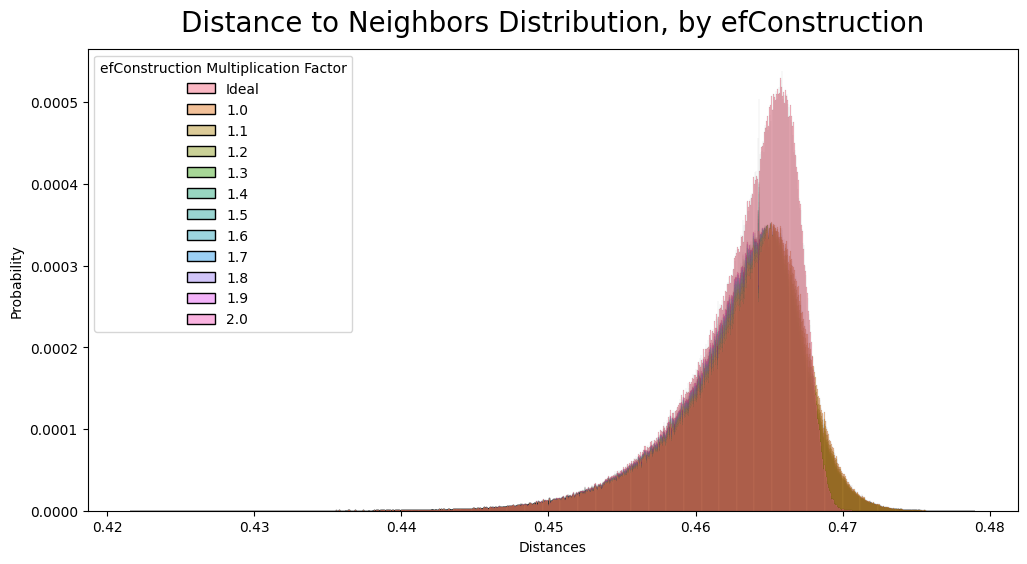

In [157]:
plt.figure(figsize=(12,6))
sns.histplot(efConst_dist_df, x='Distances', hue='efConstruction Multiplication Factor', palette='husl', stat='probability')
plt.title(f'Distance to Neighbors Distribution, by efConstruction', fontsize=20, y=1.02)
plt.show()